In [ ]:
#importing package
# %%capture
import sys
!pip install eli5
!pip install pandas-profiling==2.*
!pip install category_encoders
!pip install pdpbox

In [ ]:
#importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import datetime
import plotly.express as px
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score

In [ ]:
# reading in data
# reading in species csv file
dfs= pd.read_csv('https://raw.githubusercontent.com/TLG229/test-repo/master/whaling_species.csv')

In [ ]:
# reading in voyage csv file
dfv= pd.read_csv('https://raw.githubusercontent.com/TLG229/test-repo/master/voyages.csv', encoding='cp1252')

# data wrangling and feature engineering

In [ ]:
# dropping unecessary columns in species df

dfs.drop(columns=['PlaceName', 'Source', 'sequence'], inplace=True)

In [ ]:
# dropping unecessary columns in voyage df

dfv.drop(columns=['dayOut', 'dayIn','yearOut','yearIn', 'agentID', 'masterID', 'vesselID', 'aowlLink', 'builtDate'], inplace=True)

In [ ]:
#merging dataframes

dfm=pd.merge(dfs, dfv, on='VoyageID')

In [ ]:
#dropping 'VoyageID' due to high cardinality
dfm.drop(columns=['VoyageID'], inplace=True)
#droping repeat rows (observations)
dfm.drop_duplicates(inplace=True)

In [ ]:
#concatinating Month, Day, & Year of observation into single column
dfm['date'] = dfm['Month'].astype(str) + '-'+ dfm['Day'].astype(str) + '-'+ dfm ['Year'].astype(str) 

In [ ]:
#coverting 'date' to datetime
dfm['date'] = pd.to_datetime(dfm['date'])

In [ ]:
#dropping the columns no longer needed
dfm.drop(columns=['Day'], inplace=True)

In [ ]:
dfm.shape

(462657, 13)

In [ ]:
#setting 'date' as index
dfm.set_index('date', inplace=True)

In [ ]:
dfm['Encounter'].value_counts()

NoEnc     389383
Sight      44642
Strike     28632
Name: Encounter, dtype: int64

In [ ]:
dfm.head()

,Lat,Lon,Month,Year,Encounter,Species,NTried,port,bone,sperm,oil,rig
date,,,,,,,,,,,,
1875-08-09,41.64,-70.93,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark
1875-08-10,40.75,-70.75,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark
1875-08-11,39.66,-70.33,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark
1875-08-12,39.26,-69.41,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark
1875-08-13,38.80,-67.83,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark


In [ ]:
#converting Encounters into numbers - Strike (killed) = 1, NoEnc and Sight = 0
dfm['killed'] = dfm['Encounter'].astype(str).map(lambda x: 1 if 'Strike' in x
                                                             else 0 if 'NoEnc' in x 
                                                             else 0 if 'Sight' in x 
                                                             else"")
    

In [ ]:
dfm['Species'].value_counts()

Sperm       23625
Whale       20954
Right       15288
Finback      3706
Pilot        2725
Bowhead      2455
Humpback     2326
Grampus      1014
Gray          589
Killer        304
Blue          227
Dolphin        16
Name: Species, dtype: int64

In [ ]:
dfm['species_num'] = dfm['Species'].astype(str).map(lambda x: 1 if 'Sperm' in x
                                                             else 0 if '0' in x 
                                                             else 2 if 'Whale' in x 
                                                             else 3 if 'Right' in x
                                                             else 4 if 'Finback' in x 
                                                             else 5 if 'Pilot' in x 
                                                             else 6 if 'Bowhead' in x
                                                             else 7 if 'Humpback' in x 
                                                             else 8 if 'Grampus' in x 
                                                             else 9 if 'Gray' in x 
                                                             else 10 if 'Killer' in x 
                                                             else 11 if 'Blue' in x
                                                             else 12 if 'Dolphin' in x  
                                                             else"")

In [ ]:
dfm.head(2)

,Lat,Lon,Month,Year,Encounter,Species,NTried,port,bone,sperm,oil,rig,killed,species_num
date,,,,,,,,,,,,,,
1875-08-09,41.64,-70.93,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark,0,
1875-08-10,40.75,-70.75,8,1875,NoEnc,NaN,NaN,"New Bedford, MA",NaN,900,1300,Bark,0,


In [ ]:
#dropping Species
dfm.drop(columns=['Species'], inplace = True)

In [ ]:
dfm['killed'].nunique()

2

In [ ]:
dfm['killed'].value_counts()

0    434025
1     28632
Name: killed, dtype: int64

In [ ]:
#dropping Encounter column
dfm.drop(columns=['Encounter'], inplace = True)

In [ ]:
#replacing NaN's with 1's or 0's depending on what's needed
dfm['bone'] = dfm['bone'].fillna(0)
dfm['sperm'] = dfm['sperm'].fillna(0)
dfm['oil'] = dfm['oil'].fillna(0)
dfm['rig'] = dfm['rig'].fillna(0)
dfm['species_num']= dfm['species_num'].fillna(0)

In [ ]:
#converting these to different data types
dfm['bone'] = dfm['bone'].astype(int)
dfm['sperm'] = dfm['sperm'].astype(int)
dfm['oil'] = dfm['oil'].astype(int)

In [ ]:
#grouping by VoyageID into subset DF named df_grouped

df_grouped = dfm.groupby('date')
df_grouped.head()

,Lat,Lon,Month,Year,NTried,port,bone,sperm,oil,rig,killed,species_num
date,,,,,,,,,,,,
1875-08-09,41.64,-70.93,8,1875,NaN,"New Bedford, MA",0,900,1300,Bark,0,
1875-08-10,40.75,-70.75,8,1875,NaN,"New Bedford, MA",0,900,1300,Bark,0,
1875-08-11,39.66,-70.33,8,1875,NaN,"New Bedford, MA",0,900,1300,Bark,0,
1875-08-12,39.26,-69.41,8,1875,NaN,"New Bedford, MA",0,900,1300,Bark,0,
1875-08-13,38.80,-67.83,8,1875,NaN,"New Bedford, MA",0,900,1300,Bark,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
1863-10-28,-36.85,-54.25,10,1863,1.0,"New Bedford, MA",1900,484,289,Bark,1,3
1863-12-19,-42.78,-58.75,12,1863,1.0,"New Bedford, MA",1900,484,289,Bark,1,1
1856-12-06,-12.00,110.00,12,1856,10.0,"New Bedford, MA",28700,328,1872,Ship,1,1


In [ ]:
dfm.drop(columns=['NTried'], inplace = True)

# EDA

In [ ]:
#panda profiling report
from pandas_profiling import ProfileReport
profile = ProfileReport(dfm, minimal=True).to_notebook_iframe()

profile

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# how is the target data distributed?
dfm['killed'].value_counts(normalize=True)

0    0.938114
1    0.061886
Name: killed, dtype: float64

In [ ]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462657 entries, 1875-08-09 to 1876-03-02
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Lat          462657 non-null  float64
 1   Lon          462657 non-null  float64
 2   Month        462657 non-null  int64  
 3   Year         462657 non-null  int64  
 4   port         462657 non-null  object 
 5   bone         462657 non-null  int64  
 6   sperm        462657 non-null  int64  
 7   oil          462657 non-null  int64  
 8   rig          462657 non-null  object 
 9   killed       462657 non-null  int64  
 10  species_num  462657 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 42.4+ MB


#Splitting the Data

In [ ]:
#Splitting target variable and feature matrix

X = dfm.drop('killed', axis=1)
y = dfm['killed']

In [ ]:
# #Splitting data into training, validation and test sets
cutoff_1 = '01-01-1900'
cutoff_2 = '12-31-1907'

#training
mask_train = X.index < cutoff_1
X_train, y_train = X.loc[mask_train], y.loc[mask_train]

#validation
mask_val = (X.index >= cutoff_1)&(X.index <= cutoff_2)
X_val, y_val = X.loc[mask_val], y.loc[mask_val]

#test
mask_test = X.index > cutoff_2
X_test, y_test = X.loc[mask_test], y.loc[mask_test]



print('X_Train Shape', X_train.shape, 'y_train Shape:', y_train.shape, 'X_val Shape:', X_val.shape, 'y_val Shape:', y_val.shape, 'X_test Shape', X_test.shape, 'y_test Shape:', y_test.shape)

# X = dfm.drop(['species_enumerated'], axis=1)
# y = dfm['species_enumerated']
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)


X_Train Shape (459498, 10) y_train Shape: (459498,) X_val Shape: (1781, 10) y_val Shape: (1781,) X_test Shape (1378, 10) y_test Shape: (1378,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.940964
1    0.059036
Name: killed, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.518248
1    0.481752
Name: killed, dtype: float64

#Establish Baseline

In [ ]:
print('Baseline accuracy is {:.4f}.'.format(y_train.value_counts(normalize=True).max()))

Baseline accuracy is 0.9410.


#Builidng Models

In [ ]:
rf = make_pipeline(ce.OrdinalEncoder(),
                   SimpleImputer(),
                   RandomForestClassifier(random_state=42))
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['port', 'rig', 'species_num'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'port',
                                          'data_type': dtype('O'),
                                          'mapping': New Bedford, MA                  1
Sippican, MA                     2
Mystic, CT                       3
Provincetown, MA                 4
Nantucket, MA                    5
Mattapoisett, MA                 6
Wareham, MA                      7
Fall River, MA                   8
Rochester, MA (Mattapoisett)     9...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                    

In [ ]:
print('Training Accuracy LR:', rf.score(X_train, y_train))
print('Validation Accuracy LR', rf.score(X_val, y_val))

Training Accuracy LR: 0.9987856312758706
Validation Accuracy LR 0.9752947782144863


In [ ]:
#XGBoost
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,
                 n_jobs=10))

model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['port', 'rig', 'species_num'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'port',
                                          'data_type': dtype('O'),
                                          'mapping': New Bedford, MA                  1
Sippican, MA                     2
Mystic, CT                       3
Provincetown, MA                 4
Nantucket, MA                    5
Mattapoisett, MA                 6
Wareham, MA                      7
Fall River, MA                   8
Rochester, MA (Mattapoisett)     9...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                             

In [ ]:
#Checking Metrics
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.9617147408693836
XGBoost Validation Accuracy: 0.9696799550814149


Text(0.5, 1.0, 'Feature Importances for Model XGB Classifier')

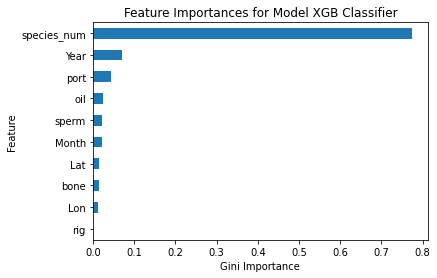

In [ ]:
#Feature Importances
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel("Feature")
plt.title('Feature Importances for Model XGB Classifier')

#Checking Metrics

In [ ]:
print('XGBOOST')
print(classification_report(y_val, model_xgb.predict(X_val))) # VALIDATION DATA

XGBOOST
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       923
           1       0.95      0.98      0.97       858

    accuracy                           0.97      1781
   macro avg       0.97      0.97      0.97      1781
weighted avg       0.97      0.97      0.97      1781



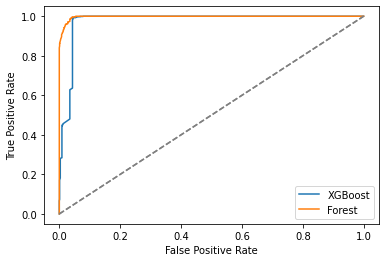

In [ ]:
xgb = plot_roc_curve(model_xgb, X_val, y_val, label='XGBoost')
rf = plot_roc_curve(rf, X_val, y_val, ax=xgb.ax_, label='Forest')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [ ]:
print('XGBoost: ROC-AUC Score:', roc_auc_score(y_val, model_xgb.predict(X_val)))

XGBoost: ROC-AUC Score: 0.9701730194687942


#Communicate Results


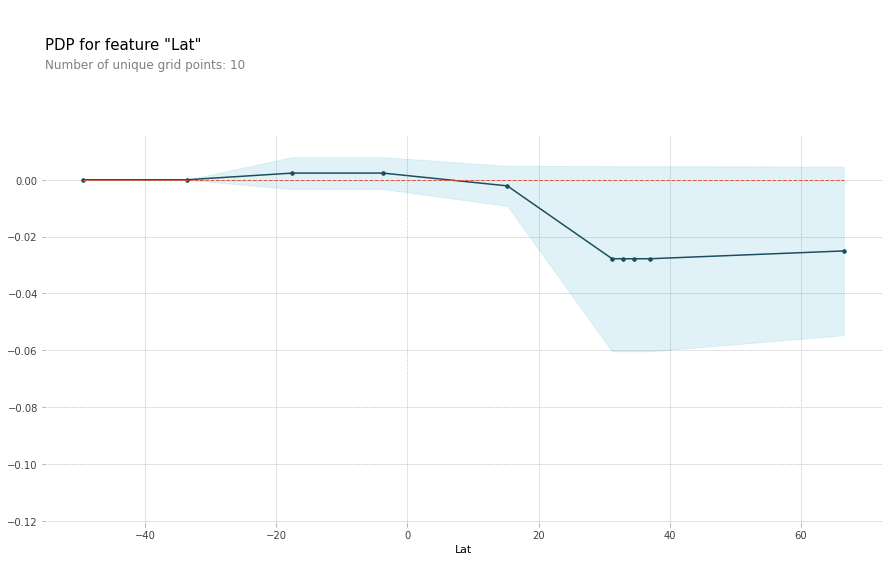

In [ ]:
#PDP Plot for Latitude
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Lat'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_test,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

# interpretation - as latitude increases, associated kills go down 

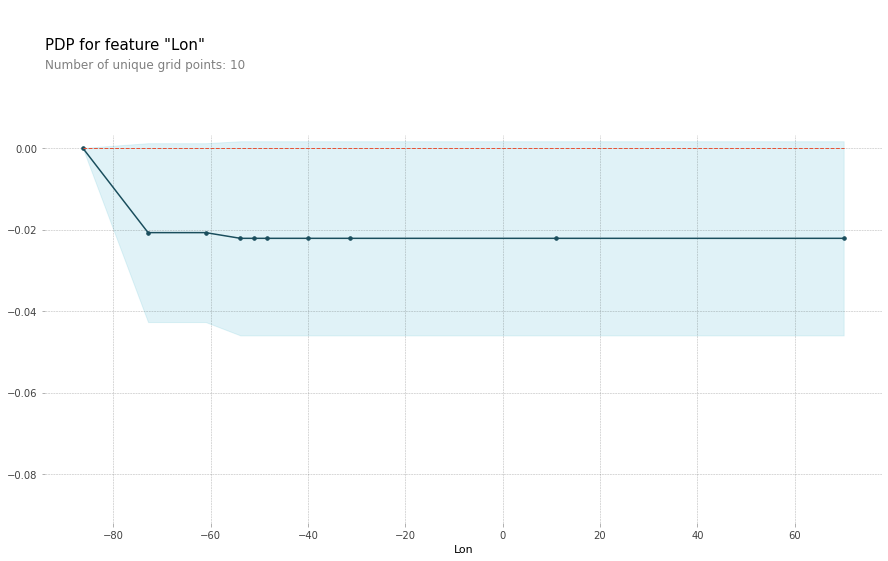

In [ ]:
#PDP Plot for Latitude
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Lon'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_test,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

#interpretation - as longitude increases, there is a negative influence on kills


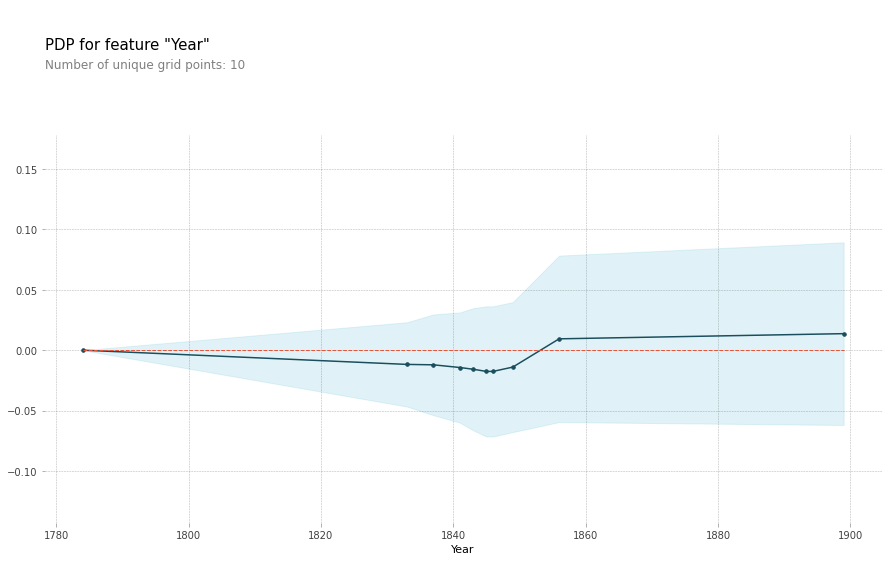

In [ ]:
feature = 'Year'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

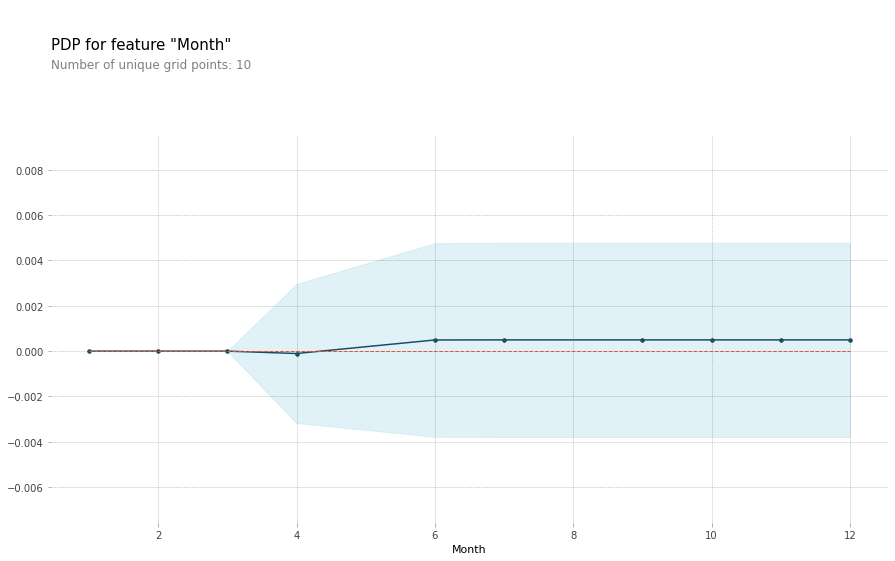

In [ ]:
feature = 'Month'

#Isolate
isolate = pdp_isolate(
    model = model_xgb,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature);

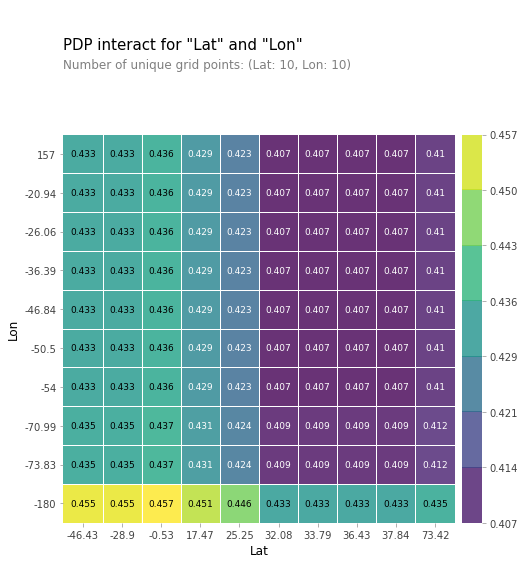

In [ ]:
#pdp interact plot -
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Lat', 'Lon']

interact = pdp_interact(
    model = model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot (interact, plot_type='grid', feature_names=features);

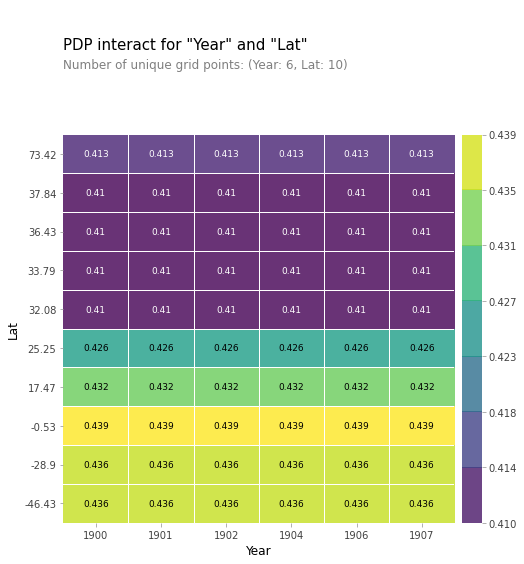

In [ ]:
#pdp interact plot 

features = ['Year', 'Lat']

interact = pdp_interact(
    model = model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot (interact, plot_type='grid', feature_names=features);

#Shapley Values on individual predictions


In [ ]:
row = X_train.iloc[[32460]]

In [ ]:
#what does model predict for this obsevation? - predicted no kill
model_xgb.predict(row)

array([0])